In [3]:
import numpy as np
from tqdm import tqdm
import anndata as ad
import sys
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.io import savemat, loadmat
import os
import pandas as pd

## Load data

In [4]:
data_folder = 'data/thomsonlab_signaling/'
large_data_folder = 'large_data/thomsonlab_signaling/'
fig_folder = 'figure/thomsonlab_signaling/'

In [5]:
cadata = ad.read_h5ad(large_data_folder + 'thomsonlab_signaling_filtered_2500_scvi_umap.h5ad')

/Users/ygong/anaconda3/envs/be206/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [6]:
cadata.X.shape

(74347, 2500)

In [10]:
import os

os.mkdir("./test/test_signalling_0913")
os.mkdir("test/test_signalling_0913/figs")

In [11]:
seed = 0
num_spin = 20
num_pool = num_spin
num_repeat = 10
task_name = "thomsonlab_signaling"
save_path = "test/test_signalling_0913/"

## Gene Regulatory Network Reconstruction by DSPIN Class

In [8]:
from util.dspin_abstract import DSPIN

/Users/ygong/git/DSPIN-abstract/util/compute.py:653: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()


In [10]:
# Reload the Package
from importlib import reload
import util.dspin_abstract  
reload(util.dspin_abstract)  
from util.dspin_abstract import DSPIN 

In [12]:
model = DSPIN(cadata, save_path, num_spin=num_spin)

LargeDSPIN initialized.


Pre-computing
Round_1


Iteration Progress: 100%|██████████| 50/50 [00:17<00:00,  2.82it/s, Reconstruction Error=7907.39]


Round_2


Iteration Progress: 100%|██████████| 50/50 [00:17<00:00,  2.90it/s, Reconstruction Error=7914.77]


Round_3


Iteration Progress: 100%|██████████| 50/50 [00:15<00:00,  3.24it/s, Reconstruction Error=7906.59]


Round_4


Iteration Progress: 100%|██████████| 50/50 [00:13<00:00,  3.58it/s, Reconstruction Error=7918.48]


Round_5


Iteration Progress: 100%|██████████| 50/50 [00:17<00:00,  2.92it/s, Reconstruction Error=7903.78]


Round_6


Iteration Progress: 100%|██████████| 50/50 [00:24<00:00,  2.05it/s, Reconstruction Error=7906.32]


Round_7


Iteration Progress: 100%|██████████| 50/50 [00:20<00:00,  2.47it/s, Reconstruction Error=7900.61]


Round_8


Iteration Progress: 100%|██████████| 50/50 [00:14<00:00,  3.36it/s, Reconstruction Error=7904.43]


Round_9


Iteration Progress: 100%|██████████| 50/50 [00:13<00:00,  3.70it/s, Reconstruction Error=7902.14]


Round_10


Iteration Progress: 100%|██████████| 50/50 [00:14<00:00,  3.54it/s, Reconstruction Error=7913.64]
/Users/ygong/anaconda3/envs/be206/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/ygong/anaconda3/envs/be206/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Discretize ONMF representation into three states


/Users/ygong/anaconda3/envs/be206/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


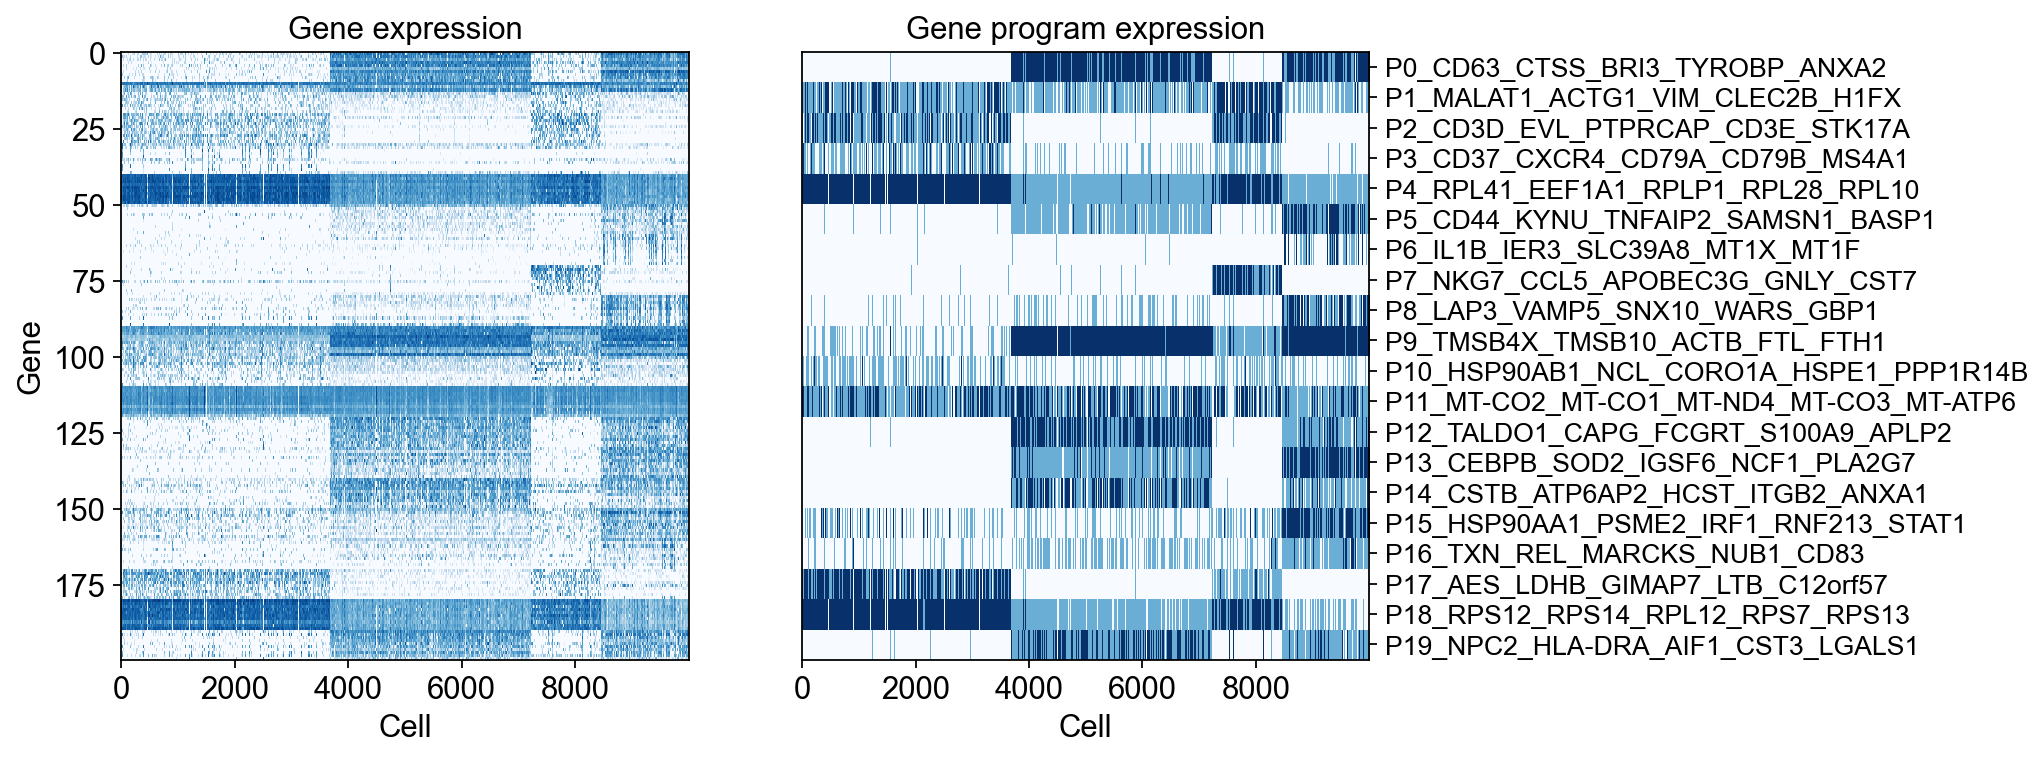

In [13]:
model.gene_program_discovery(sample_column_name= 'sample_batch')

In [14]:
example_list = ['TNFA_200ng_mL_1-COVID-1', 'IL7_50ng_mL_1-COVID-1', 'LPS_50ng_mL_1-COVID-1', 'CCL2_200ng_mL_1-COVID-1', 'CONTROL_1-COVID-1']

In [15]:
model.network_infer(example_list=example_list)

Progress: 13, Network gradient: 18.693069
Progress: 20, Network gradient: 9.785056
Progress: 26, Network gradient: 5.657448
Progress: 33, Network gradient: 4.974407
Progress: 40, Network gradient: 2.802410
Progress: 46, Network gradient: 1.773043
Progress: 53, Network gradient: 1.696144
Progress: 60, Network gradient: 1.716834
Progress: 66, Network gradient: 1.305103
Progress: 73, Network gradient: 1.385463
Progress: 80, Network gradient: 1.261862
Progress: 86, Network gradient: 0.974751
Progress: 93, Network gradient: 0.861371
Progress: 100, Network gradient: 0.864591


In [17]:
cur_j, cur_h = model.network, model.responses

In [62]:
def common_hyperparas_setting(self, example_list=None) -> dict:
        raw_data = self.raw_data
        num_spin = self.num_spin

        if example_list:
            print('Example list is provided. Only use the samples in the list.')
            example_list_ind = [list(self.samp_list).index(samp) for samp in example_list]
            raw_data = raw_data[example_list_ind]

        print('Number of samples: ', len(raw_data))
        num_spin = raw_data[0][0].shape[0]
        num_samp = len(raw_data)
        rec_all_corr = np.zeros((num_spin, num_spin, num_samp))
        rec_all_mean = np.zeros((num_spin, num_samp))

        for ii in range(num_samp):
            rec_all_corr[:, :, ii] = raw_data[ii][0]
            rec_all_mean[:, ii] = raw_data[ii][1].flatten()
        
        cur_j = np.zeros((num_spin, num_spin))
        cur_h = np.zeros((num_spin, num_samp))
        data_dir = self.save_path + 'dspin_python/'
        task_name = data_dir + 'train_log'

        train_dat = {'cur_j': cur_j, 'cur_h': cur_h, 'task_name': task_name,
                     'rec_all_corr': rec_all_corr, 'rec_all_mean': rec_all_mean}

        dir_list = [data_dir, data_dir + 'train_log']
        for directory in dir_list:
            if not os.path.exists(directory):
                os.makedirs(directory)

        return train_dat

In [66]:
a.example_list

In [77]:
common_hyperparas_setting(a, a.example_list)

Example list is provided. Only use the samples in the list.


TypeError: 'NoneType' object is not iterable

In [75]:
a.example_list = example_list

In [76]:
a.example_list

['TNFA_200ng_mL_1-COVID-1',
 'IL7_50ng_mL_1-COVID-1',
 'LPS_50ng_mL_1-COVID-1',
 'CCL2_200ng_mL_1-COVID-1',
 'CONTROL_1-COVID-1']

In [33]:
b = DSPIN(cadata, save_path, num_spin=num_spin, num_repeat=1)

LargeDSPIN initialized.


/Users/ygong/git/DSPIN-abstract/util/dspin_abstract.py:57: UserWarning: num_spin larger than 10 takes long time in Python. Please use computing clusters for larger num_spin.
  warnings.warn("num_spin larger than 10 takes long time in Python. Please use computing clusters for larger num_spin.")


### Verification the Correctness of ONMF Representation

In [ ]:
from util.plotting import onmf_gene_program_info

num_gene_show = 20
features = a.onmf_summary.components_
gene_name = cadata.var_names

onmf_gene_program_info(features, gene_name, num_gene_show, fig_folder)

#### Visualization of gene program decomposition

In [39]:
from importlib import reload
import util.compute
reload(util.compute)   

<module 'util.compute' from '/Users/ygong/git/DSPIN-abstract/util/compute.py'>

In [10]:
a.compute_onmf_rep_ori()

In [11]:
a.discretize()

100%|██████████| 20/20 [00:03<00:00,  6.56it/s]


In [12]:
a.onmf_rep_tri

array([[0. , 0. , 0. , ..., 1. , 0. , 0.5],
       [1. , 0. , 0. , ..., 1. , 0. , 0.5],
       [0.5, 0.5, 0. , ..., 1. , 0. , 0. ],
       ...,
       [0. , 0.5, 0.5, ..., 0.5, 0. , 0. ],
       [0. , 0.5, 0. , ..., 0.5, 0.5, 0. ],
       [0. , 0.5, 0.5, ..., 0.5, 0. , 0. ]])

In [13]:
onmf_rep_tri = a.onmf_rep_tri

In [14]:
from util.plotting import temporary_spin_name, gene_program_decomposition

In [47]:
spin_name = temporary_spin_name('test/test_signalling/onmf_gene_list_20.csv')

In [17]:
fig_folder = '/Users/ygong/git/DSPIN-abstract/test/test_signalling/figs'

In [19]:
gene_program_decomposition(a.onmf_summary, num_spin, spin_name, a.gene_matrix_large, onmf_rep_tri, fig_folder)

TypeError: tuple indices must be integers or slices, not tuple

In [15]:
gene_matrix = a.gene_matrix_large

In [23]:
std = a.matrix_std

In [4]:
import networkx as nx
import matplotlib.patheffects as patheffects

def plot_jmat_network(G, j_mat, ax, nodesz=1, linewz=1, node_color='k', pos=None): 
    
    self_loops = [(u, v) for u, v in G.edges() if u == v]
    G.remove_edges_from(self_loops)

    eposi= [(u, v) for (u,v,d) in G.edges(data=True) if d['weight'] > 0]
    wposi= np.array([d['weight'] for (u,v,d) in G.edges(data=True) if d['weight'] > 0])

    enega = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] < 0]
    wnega = np.array([d['weight'] for (u,v,d) in G.edges(data=True) if d['weight'] < 0])

    col1 = '#f0dab1'
    # nx.draw_networkx_nodes(G, pos, ax=ax, node_size=61.8 * nodesz, node_color=col1, edgecolors='None')
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=61.8 * nodesz, node_color=node_color, edgecolors='k')

    sig_fun = lambda xx : (1 / (1 + np.exp(- 5 * (xx + cc))))
    cc = np.max(np.abs(j_mat)) / 10
    # edges
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=eposi, width=linewz * wposi, 
                            edge_color='#3285CC', alpha=sig_fun(wposi))

    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=enega, width=- linewz * wnega, 
                            edge_color='#E84B23', alpha=sig_fun(- wnega))

    margin = 0.2
    plt.margins(x=0.1, y=0.1)

    ax.set_axis_off()
    ax.set_aspect('equal')
    return ax 

In [48]:
gene_list = spin_name

In [49]:
gene_list

['P0_PPP1R14B_APOBEC3G_CMC1_GZMM_LYAR',
 'P1_ATM_GCC2_PPP2R5C_TNRC6B_NKTR',
 'P2_FABP5_MFSD12_HMG20B_ALAS1_CD83',
 'P3_PSME2_IRF1_STAT1_LAP3_GBP1',
 'P4_NFKBIA_C15orf48_IL8_PLAUR_KYNU',
 'P5_MALAT1_MT-CO1_MT-CO2_MT-ND4_MT-CO3',
 'P6_MT-ND2_MT-ND1_TMSB10_RPL41_EEF1A1',
 'P7_GABARAP_LGMN_ZFP36_CD163_FCGR3A',
 'P8_CYBA_S100A6_NEAT1_S100A11_CD63',
 'P9_CD37_CD79A_CXCR4_CD79B_MS4A1',
 'P10_FOS_IER2_FCN1_TGFBI_FUCA1',
 'P11_AES_LDHB_GIMAP7_LTB_C12orf57',
 'P12_ATP6AP2_FCGRT_APLP2_ACP5_NCF2',
 'P13_SNHG8_GIMAP1_PIK3IP1_KLF2_CCR7',
 'P14_REL_BASP1_PPA1_MARCKS_HSPD1',
 'P15_HBB_HBA2_HBA1_SNCA_SLC25A37',
 'P16_NKG7_GNLY_CCL5_CST7_GZMA',
 'P17_RPL28_RPS2_RPS28_RPL11_RPS15',
 'P18_MT2A_MT1X_MT1F_MT1G_MT1E',
 'P19_CCNG1_AQP3_TC2N_CCDC104_TSHZ2']

In [50]:
cur_j = a.network

In [53]:
j_mat = a.responses

In [2]:
def format_label(label):
    parts = label.split('_')
    parts[1] = parts[1] + '\n'
    parts[3] = parts[3] + '\n'
    return '_'.join(parts)

In [3]:
label = 'P0_PPP1R14B_APOBEC3G_CMC1_GZMM_LYAR'
print(format_label(label))

P0_PPP1R14B
_APOBEC3G_CMC1
_GZMM_LYAR


In [57]:
def adjust_label_position(pos, offset=0.1):
    """Move labels radially outward from the center by a given offset."""
    adjusted_pos = {}
    for node, coordinates in pos.items():
        theta = np.arctan2(coordinates[1], coordinates[0])
        radius = np.sqrt(coordinates[0]**2 + coordinates[1]**2)
        adjusted_pos[node] = (coordinates[0] + np.cos(theta)*offset, coordinates[1] + np.sin(theta)*offset)
    return adjusted_pos

In [5]:
sc.set_figure_params(figsize=[18, 14])

nodesz = 2
linewz = 3
node_color = ['#f0dab1'] * num_spin
node_label = np.array([format_label(label) for label in gene_list])


fig, grid = sc.pl._tools._panel_grid(0.1, 0.1, ncols=2, num_panels=2)

cur_j_filt = cur_j.copy()
cur_j_filt[np.abs(cur_j_filt) < np.percentile(np.abs(cur_j_filt), 40)] = 0
G = nx.from_numpy_array(cur_j_filt)
pos = nx.circular_layout(G)

ax = plt.subplot(grid[1])
ax = plot_jmat_network(G, cur_j_filt, ax, nodesz=nodesz, linewz=linewz, node_color=node_color, pos=pos)

path_effect = [patheffects.withStroke(linewidth=4, foreground='w')]

adjusted_positions = adjust_label_position(pos, 0.2)
for ii in range(num_spin):
    x, y = adjusted_positions[ii]
    text = plt.text(x, y, node_label[ii], fontsize=13, color='k', ha='center', va='center')
    text.set_path_effects(path_effect)
ax.set_title('D-SPIN')


NameError: name 'sc' is not defined

In [94]:
cadata.X

array([[1.7934282 , 0.        , 0.        , ..., 2.3997154 , 0.        ,
        2.7744658 ],
       [0.        , 0.        , 0.        , ..., 1.9105867 , 0.        ,
        3.1792285 ],
       [2.0357234 , 0.        , 0.        , ..., 3.318944  , 0.        ,
        3.5348232 ],
       ...,
       [0.        , 0.        , 0.        , ..., 3.202539  , 1.6553632 ,
        4.3776374 ],
       [0.7115944 , 0.        , 0.        , ..., 3.0793717 , 1.1231337 ,
        4.5687737 ],
       [0.        , 0.        , 0.        , ..., 3.04916   , 0.54102814,
        4.399258  ]], dtype=float32)

In [97]:
df = pd.DataFrame(cadata.X, columns=cadata.var_names)

In [98]:
filtered_df = df.loc[:, (df==0).sum(axis=0) < df.shape[0] * 0.98]

In [100]:
filtered_data = cadata.X[:, np.sum(cadata.X!=0, axis=0) >= cadata.X.shape[0]*0.02]

In [102]:
filtered_data.shape

(74347, 2500)

In [107]:
cadata2 = cadata.copy()

In [108]:
cadata2.X = cadata2.X[:, 2:]

ValueError: Data matrix has wrong shape (74347, 2498), need to be (74347, 2500).

In [101]:
cadata.X = filtered_data

In [1]:
cadata.X.shape

NameError: name 'cadata' is not defined

In [104]:
len(cadata.var_names)

2500

In [109]:
adata_filt = cadata[cadata.X[:, 2:]]

ValueError: Buffer has wrong number of dimensions (expected 1, got 0)

In [114]:
columns_to_keep = np.sum(cadata.X!=0, axis=0) >= cadata.X.shape[0]*0.05

adata_filtered = cadata[:, columns_to_keep]


In [113]:
columns_to_keep

matrix([[ True,  True,  True, ...,  True,  True,  True]])

In [115]:
adata_filtered

View of AnnData object with n_obs × n_vars = 74347 × 1619
    obs: 'cell_barcode', 'sample_id', 'batch', 'sample_number', 'sample_batch', 'leiden'
    var: 'gene_ENSG', 'gene_name'
    uns: 'log1p'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts'

In [116]:
filter_threshold = 0.05
counts_threshold = int(cadata.shape[0] *  filter_threshold)


In [117]:
sc.pp.filter_genes(cadata, min_counts=counts_threshold)

In [8]:
cadata.shape

(74347, 2500)

In [5]:
cur_onmf = np.load('test/test_signalling6/onmf_20_1.npy', allow_pickle=True).item()

In [7]:
cur_onmf.components_.shape

(20, 2500)

In [10]:
onmf_path = 'test/test_signalling6/'

In [16]:
gene_matrix = cadata.X

In [14]:
num_repeat = 10
num_pool = 20

In [17]:
rec_components = np.zeros((num_repeat, num_pool, gene_matrix.shape[1]))

for ii in range(num_repeat):
    cur_onmf = np.load('%sonmf_%d_%d.npy' % (onmf_path, num_pool, ii + 1), allow_pickle=True).item()
    rec_components[ii] = cur_onmf.components_

In [19]:
rec_components.shape

(10, 20, 2500)

In [20]:
all_components = rec_components.reshape(num_repeat * num_pool, -1)

In [21]:
all_components.shape

(200, 2500)